In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import training
from classifier.test import pool_test_loop


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)# T.NormalizeScale()) #, transform=transform_fn

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


Processing...
Done!
Processing...
Done!
Processing...


KeyboardInterrupt: 

TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?

Normalization:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again. (maybe with GINConv layers, as is shown in the paper?), doesnt seem to work in this case (at least with normal data)
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input? --> try pytorch instancenorm1(?)d instead of pygs

--> try data normalization/standardization (beforehand)

23.06.2022 14:37:09 Creating Training Directory at 2022-06-23_14-37_MinCut_CG_Classifier/
23.06.2022 14:37:09 Using CUDNN Benchmark
23.06.2022 14:37:10 Loading Datasets
23.06.2022 14:37:10 Start Training


Epoch 0: Training loss 17.9179; Validation loss 22.3738, MAE: 22.2646; lr: 0.00100
	Add. Loss: Training 0.6006, Validation 0.5333
Epoch 5: Training loss 17.0831; Validation loss 21.5429, MAE: 21.7446; lr: 0.00100
	Add. Loss: Training 0.2760, Validation 0.2902
Epoch 10: Training loss 13.6606; Validation loss 18.5800, MAE: 18.8226; lr: 0.00100
	Add. Loss: Training 0.2463, Validation 0.2660
Epoch 15: Training loss 3.7087; Validation loss 13.7143, MAE: 13.9611; lr: 0.00100
	Add. Loss: Training 0.2463, Validation 0.2508
Epoch 20: Training loss 2.9049; Validation loss 14.5430, MAE: 14.7872; lr: 0.00100
	Add. Loss: Training 0.2428, Validation 0.2553
Epoch 25: Training loss 2.6815; Validation loss 15.0402, MAE: 15.2872; lr: 0.00100
	Add. Loss: Training 0.2437, Validation 0.2497
Epoch 30: Training loss 2.4978; Validation loss 15.1703, MAE: 15.4143; lr: 0.00100
	Add. Loss: Training 0.2411, Validation 0.2495
Epoch 35: Training loss 2.3349; Validation loss 14.8492, MAE: 15.0898; lr: 0.00100
	Add. 

23.06.2022 15:24:53 Training took 0.80 hours
23.06.2022 15:24:53 Minimum Training Loss -0.1806 in epoch 4965
23.06.2022 15:24:53 Minimum Validation Loss (after 0 epochs) 12.3826 in epoch 2335
23.06.2022 15:24:53 Minimum MAE (after 0 epochs) 12.8414 in epoch 2335
23.06.2022 15:24:53 Seed used for training was: 2700551470624239912


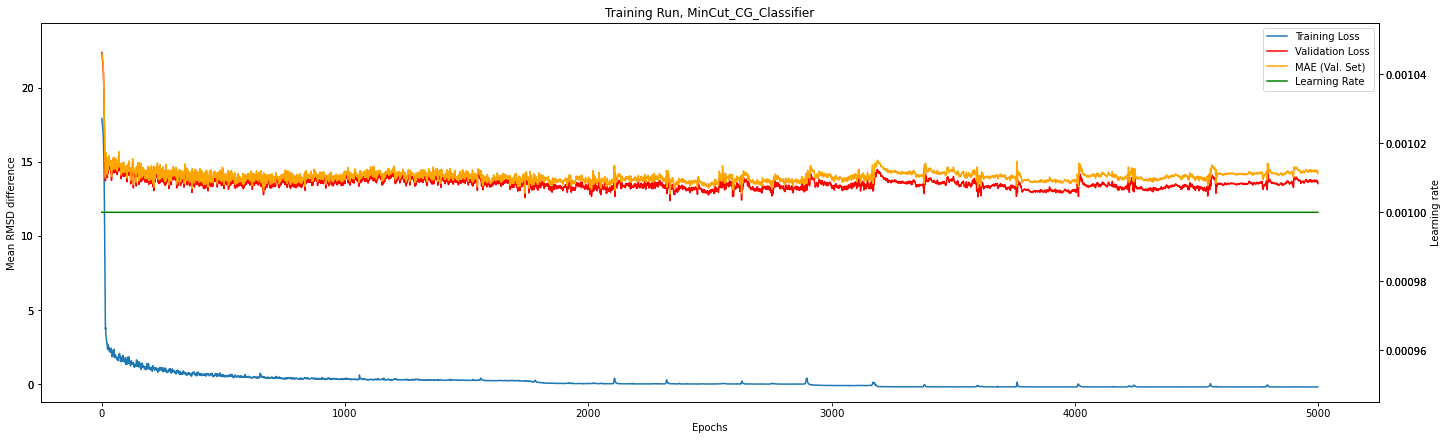

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=0,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=0)

In [3]:
#get training run data

run_dir = "run_data/2022-06-23_14-37_MinCut_CG_Classifier"
burn_in = 100

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss -0.1806 in epoch 4965
Minimum Validation Loss (after 100 epochs) 12.3826 in epoch 2335
Minimum MAE (after 100 epochs) 12.8414 in epoch 2335


Validation Loss at 2417 is 12.9199
5 before select
13.0885, 13.1663, 13.1926, 13.2812, 13.2020
5 after select
12.9680, 13.1459, 13.0979, 13.0735, 13.1374
MAE at 2417 is 13.3838


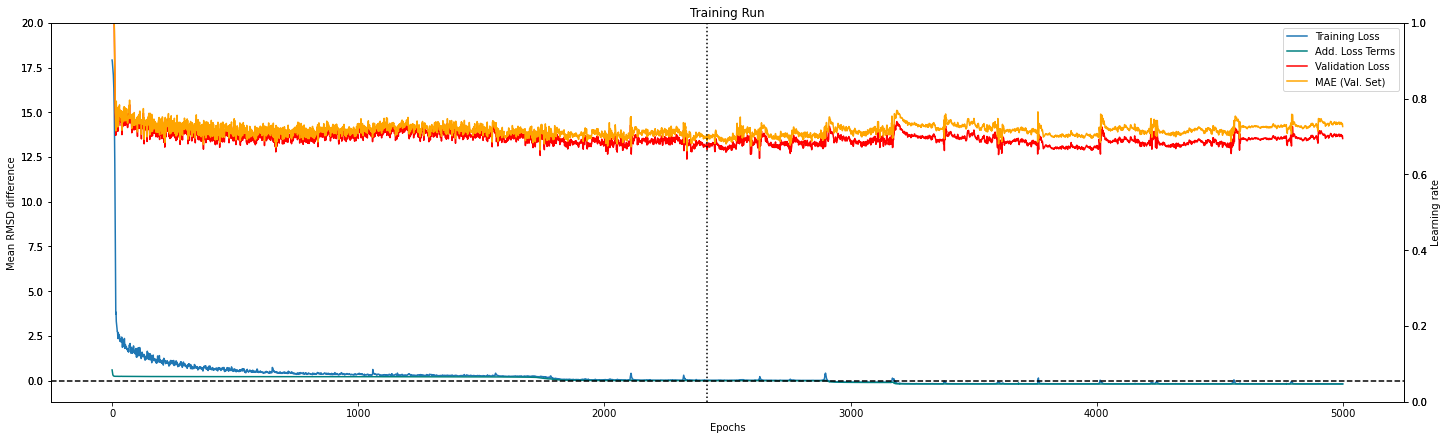

In [9]:
#plot the training run
select = 2417

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0, c = "black", ls = "--")

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 2417
Prediction below 0: Label 28.3790, Pred -18.8597
Prediction below 0: Label 22.7100, Pred -2.4665
Prediction below 0: Label 0.0000, Pred -3.1879
Prediction below 0: Label 27.7460, Pred -1.7591
Prediction below 0: Label 14.5770, Pred -4.9227
Prediction below 0: Label 11.6950, Pred -0.9159
Prediction below 0: Label 34.0510, Pred -3.0396
Prediction below 0: Label 10.9210, Pred -24.0731
Prediction below 0: Label 8.8860, Pred -21.4120
Prediction below 0: Label 26.0510, Pred -2.1349
Prediction below 0: Label 11.5730, Pred -7.1173
Prediction below 0: Label 37.7360, Pred -14.0233
Prediction below 0: Label 37.6080, Pred -5.5025
Prediction below 0: Label 35.5090, Pred -1.3102
Prediction below 0: Label 26.9080, Pred -1.2226
Prediction below 0: Label 11.5480, Pred -34.4631
Prediction below 0: Label 31.4230, Pred -24.0516
Prediction below 0: Label 23.8120, Pred -0.6225
Prediction below 0: Label 10.2290, Pred -3.8762
Prediction below 0: Label 22.3970, Pred -26.1659
Pr

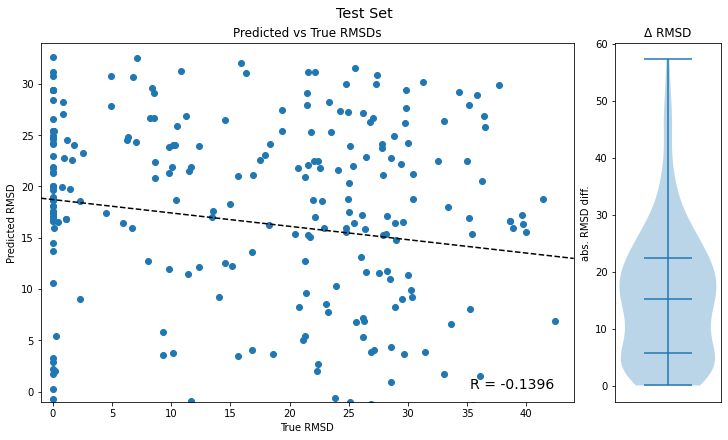

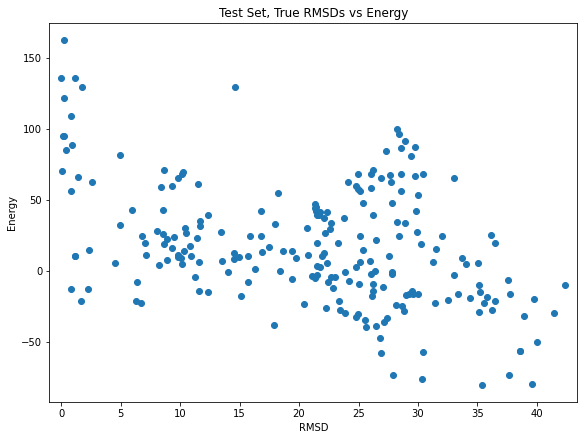

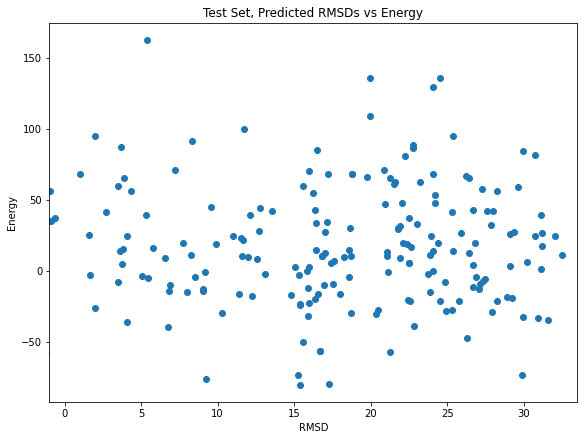

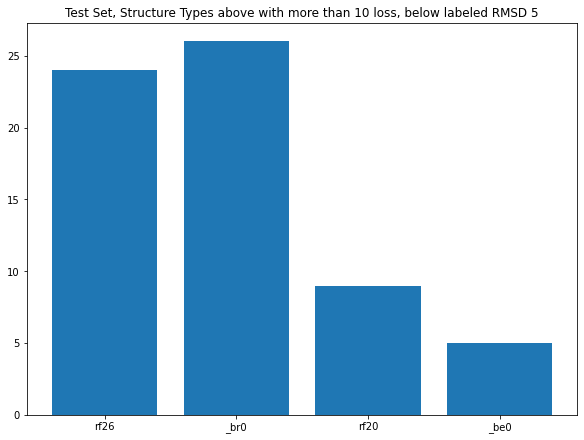

Prediction below 0: Label 20.8720, Pred -22.4488
Prediction below 0: Label 5.4960, Pred -11.3258
Prediction below 0: Label 22.9030, Pred -7.0924
Prediction below 0: Label 17.6130, Pred -5.9928
Prediction below 0: Label 13.9950, Pred -14.2766
Prediction below 0: Label 19.9370, Pred -1.2855
Prediction below 0: Label 2.4280, Pred -3.8567
Prediction below 0: Label 16.6360, Pred -10.2788
Prediction below 0: Label 28.1220, Pred -9.4764
Prediction below 0: Label 0.6990, Pred -8.3540
Prediction below 0: Label 19.8640, Pred -7.9653
Prediction below 0: Label 22.5410, Pred -2.4196
Prediction below 0: Label 0.1340, Pred -2.0781
Prediction below 0: Label 20.0430, Pred -10.0610
Prediction below 0: Label 15.9190, Pred -13.4945
Prediction below 0: Label 12.3180, Pred -3.8277
Prediction below 0: Label 29.9490, Pred -0.7830
Prediction below 0: Label 13.6040, Pred -3.4820
Prediction below 0: Label 22.5580, Pred -2.1091
Prediction below 0: Label 0.0000, Pred -24.8427
Prediction below 0: Label 19.8390, Pre

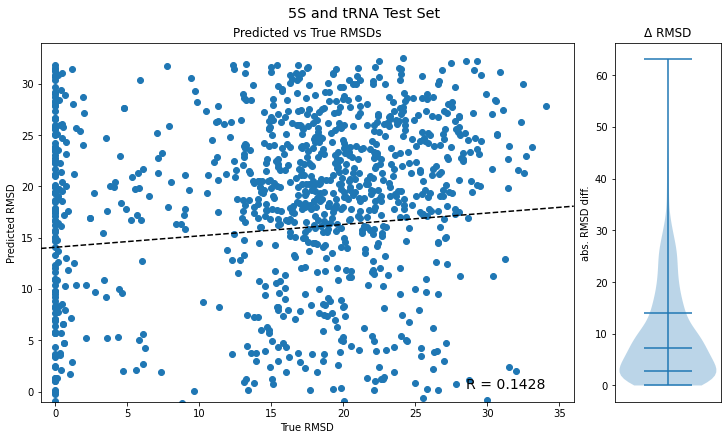

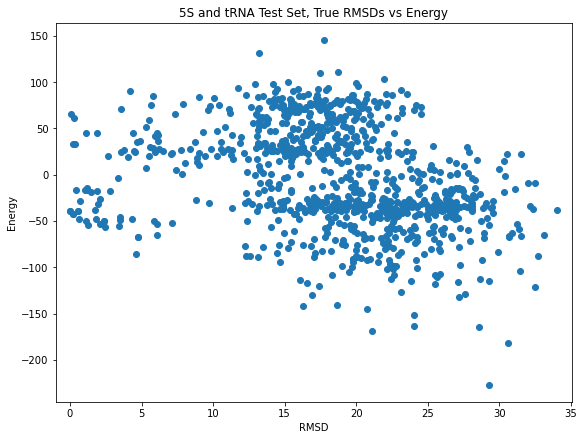

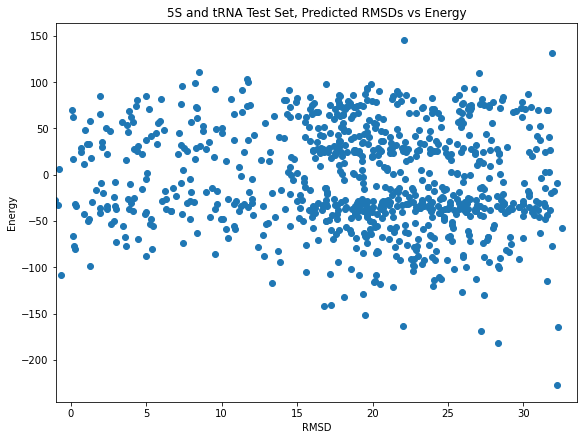

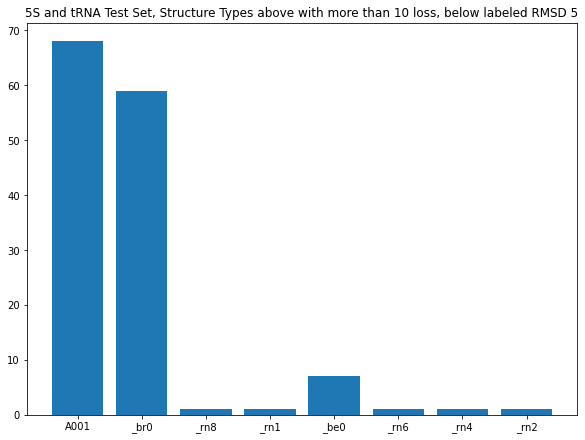

Prediction below 0: Label 12.2440, Pred -1.5057
Prediction below 0: Label 9.7280, Pred -50.9127
Prediction below 0: Label 16.1900, Pred -11.1572
Prediction below 0: Label 2.6310, Pred -3.4730
Prediction below 0: Label 14.5500, Pred -29.8826
Prediction below 0: Label 7.5170, Pred -13.8384
Prediction below 0: Label 6.7960, Pred -19.2575
Prediction below 0: Label 16.7080, Pred -13.7390
Prediction below 0: Label 30.1300, Pred -23.4448
Prediction below 0: Label 8.0450, Pred -14.5933
Prediction below 0: Label 10.0450, Pred -8.9566
Prediction below 0: Label 9.3690, Pred -7.3208
Prediction below 0: Label 24.8890, Pred -15.2112
Prediction below 0: Label 2.6830, Pred -1.0644
Prediction below 0: Label 7.5170, Pred -13.8384
Prediction below 0: Label 21.7220, Pred -12.5433
Prediction below 0: Label 32.3130, Pred -13.2862
Prediction below 0: Label 19.0110, Pred -3.4010
Prediction below 0: Label 20.8160, Pred -14.6420
Prediction below 0: Label 31.9580, Pred -6.2248
Prediction below 0: Label 2.6310, P

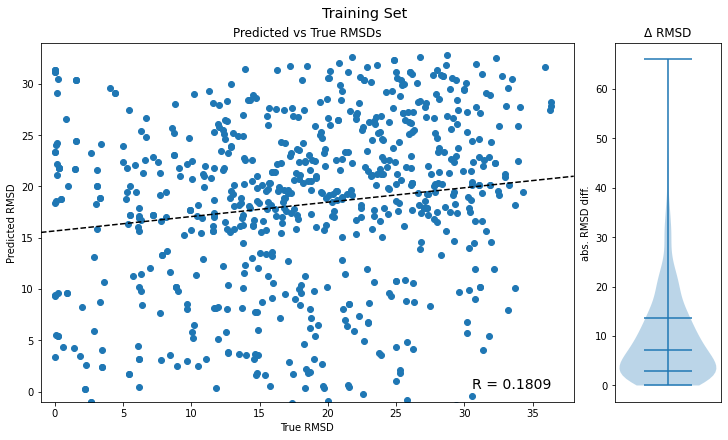

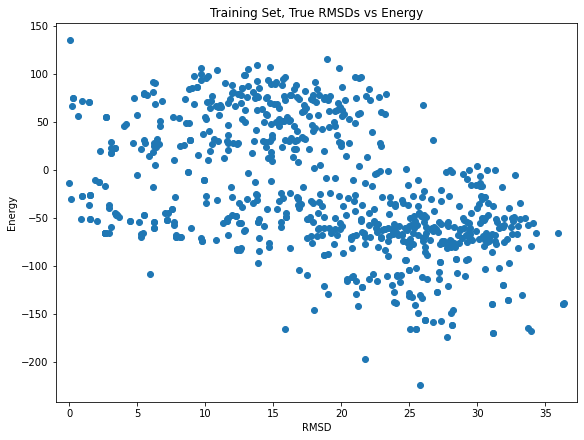

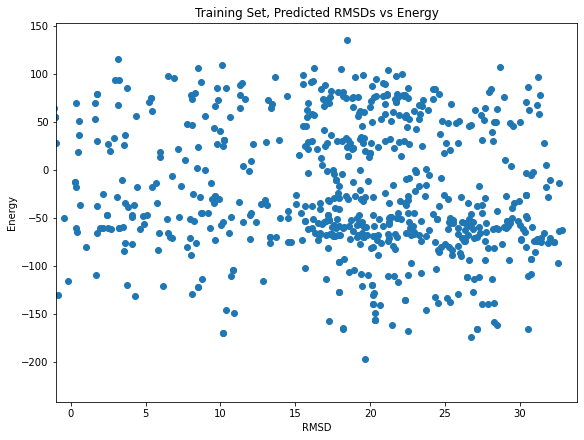

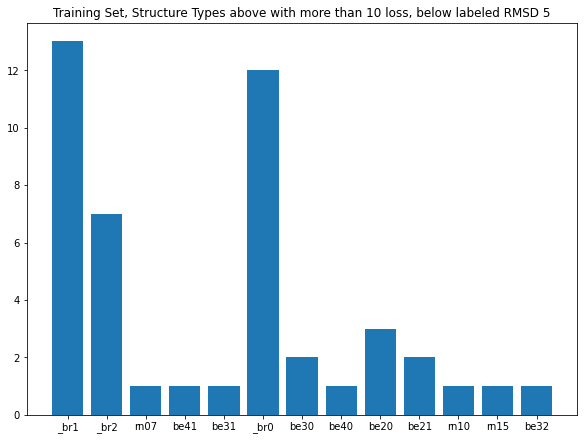

Prediction below 0: Label 8.8950, Pred -3.2563
Prediction below 0: Label 22.5180, Pred -10.0491
Prediction below 0: Label 21.8310, Pred -2.5790
Prediction below 0: Label 21.5350, Pred -1.9540
Prediction below 0: Label 9.8700, Pred -18.8585
Prediction below 0: Label 28.6800, Pred -12.3958
Prediction below 0: Label 16.2900, Pred -6.5356
Prediction below 0: Label 21.9180, Pred -11.1543
Prediction below 0: Label 0.0000, Pred -28.9454
Prediction below 0: Label 20.8350, Pred -9.3121
Prediction below 0: Label 17.0460, Pred -4.8601
Prediction below 0: Label 41.4250, Pred -1.6042
Prediction below 0: Label 40.9830, Pred -18.1341
Prediction below 0: Label 39.9400, Pred -0.6938
Prediction below 0: Label 10.2360, Pred -10.7174
Prediction below 0: Label 48.8860, Pred -9.1350
Prediction below 0: Label 36.7770, Pred -4.8361
Prediction below 0: Label 13.8260, Pred -6.1810
Prediction below 0: Label 61.9850, Pred -15.8499
Prediction below 0: Label 0.0000, Pred -7.6555
Prediction below 0: Label 0.0000, Pr

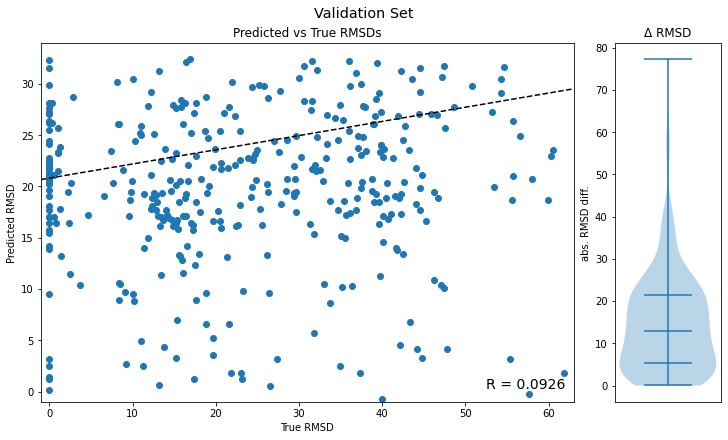

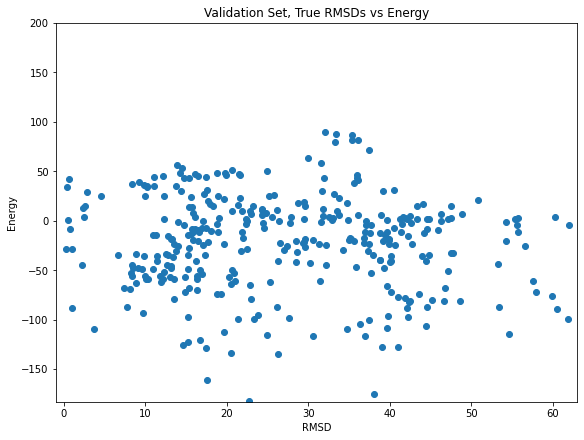

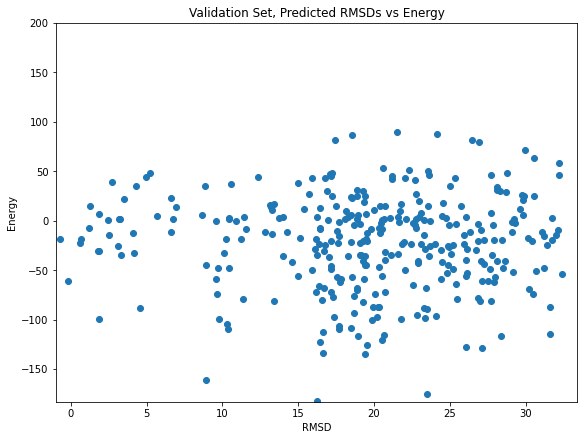

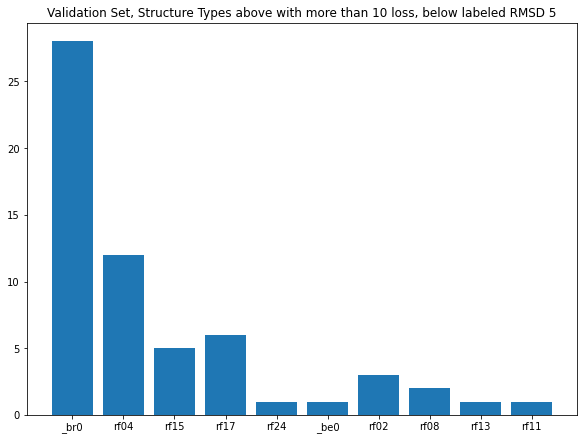

LinregressResult(slope=0.06833913077694508, intercept=19.689056993361895, rvalue=0.07828729722646023, pvalue=0.002485899994414409, stderr=0.022552559268254627, intercept_stderr=0.45576286662813675)


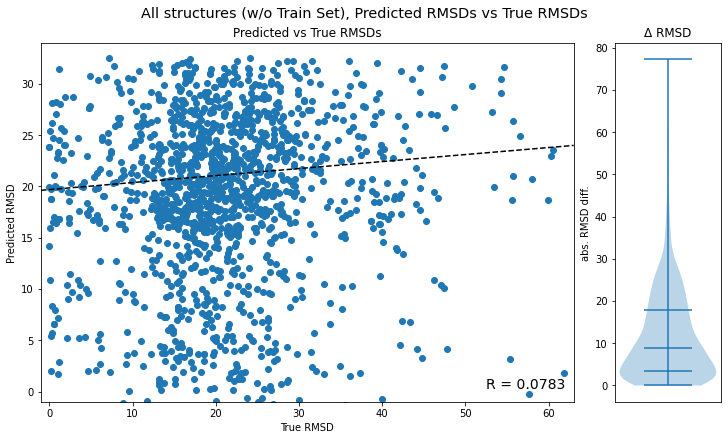

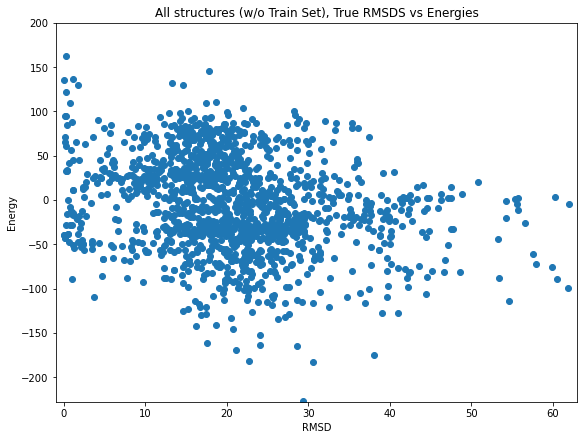

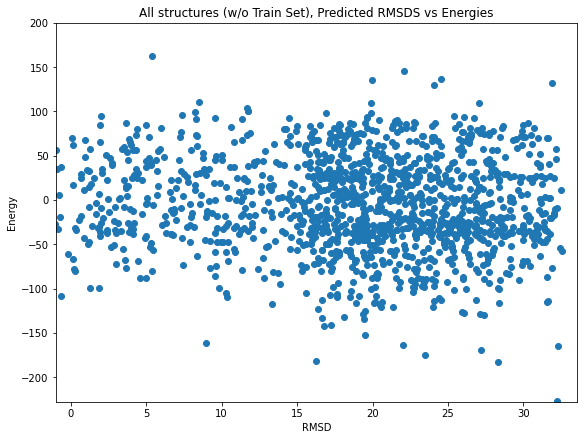

In [10]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = MinCut_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9091579813203675, intercept=1.8185265564939073, rvalue=0.9366382501401529, pvalue=2.694587713881415e-127, stderr=0.020504017003080147, intercept_stderr=0.40753690556040806)


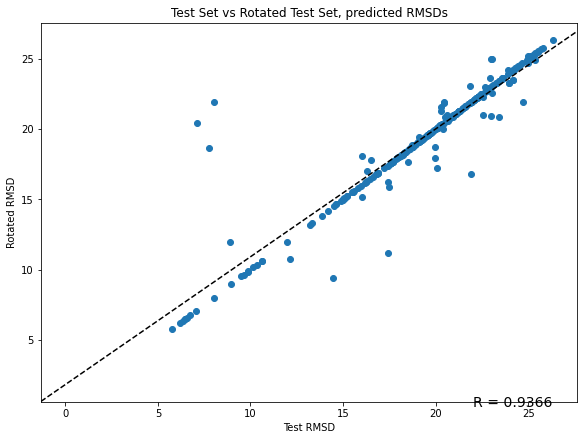

LinregressResult(slope=0.9786476636103387, intercept=0.3422918149869716, rvalue=0.9785232101141297, pvalue=1.2132055836684666e-190, stderr=0.012432089962595764, intercept_stderr=0.168440886827594)


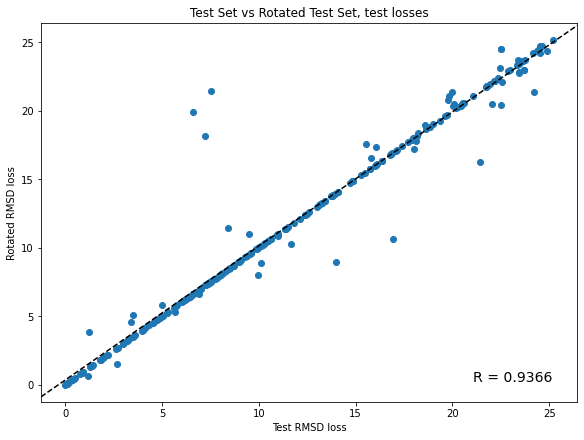

LinregressResult(slope=0.9712626165796127, intercept=0.5077173948013183, rvalue=0.9651781637725774, pvalue=0.0, stderr=0.00800650792132218, intercept_stderr=0.15077171482414378)


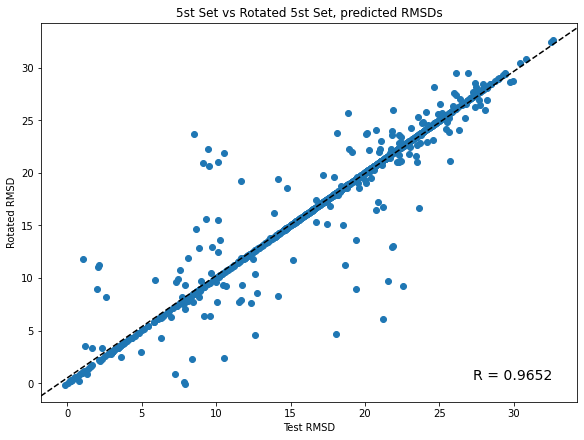

LinregressResult(slope=0.9253551594236874, intercept=0.29146281014302033, rvalue=0.9308669272310164, pvalue=0.0, stderr=0.011046561261775974, intercept_stderr=0.07107113242709055)


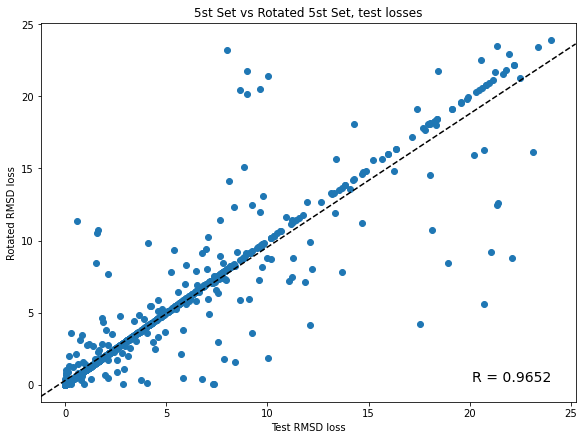

In [20]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")